In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from change_detector import OnlineSimulator, ChangeDetector

In [3]:
detector = ChangeDetector()

Signal: [6 5 6 6 6 7 0 0 8 7 7 5 1 4 6 4 1 5 0 8]
Residuals: []
Stopping rule not triggered.


False

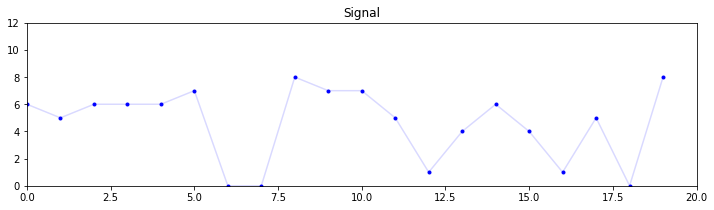

In [4]:
signal = np.random.randint(10, size=20)
print("Signal: {}".format(signal))

# reset
sim = OnlineSimulator(detector, signal)

# pass the signal the online_simulator
sim.run(plot=True)

In [5]:
class MeanDetector(ChangeDetector):
    """
    This is a simple detector that extends the base 
    ChangeDetector. 
    
    This serves as a useful "skeleton" on how to override 
    the methods of ChangeDetector.
    
    We're adding a "residual" -- we'll keep track of the 
    mean of the signal. 
    """
    def __init__(self):
        super(MeanDetector, self).__init__()

        self.total_val = 0
        # Mean is a pretty simple and useful residual
        self.mean_ = np.nan
        
    def update_residuals(self, new_signal_value):
        self._update_base_residuals(new_signal_value)
        
        self.total_val += new_signal_value
        self.mean_ = float(self.total_val) / self.signal_size
    
    def check_stopping_rules(self, new_signal_value):
        # Implement Stopping rules here
        if np.abs(new_signal_value - self.mean_) > 100: 
            self.rules_triggered = True

Residuals: ['mean_']
Stopping rule not triggered.


False

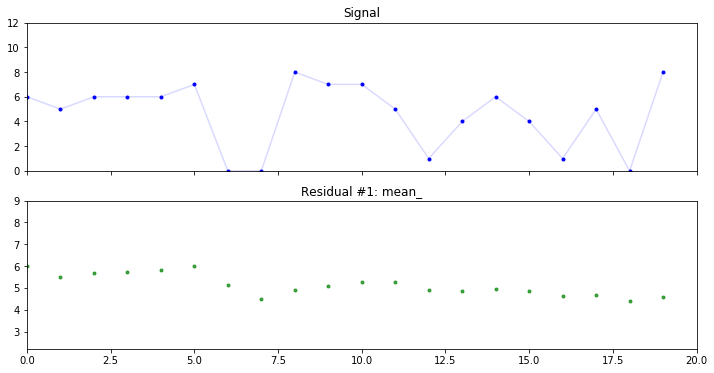

In [6]:
mean_detector = MeanDetector()
OnlineSimulator(mean_detector, signal).run()


Text(0.5,1,'sig1 : A trivial signal')

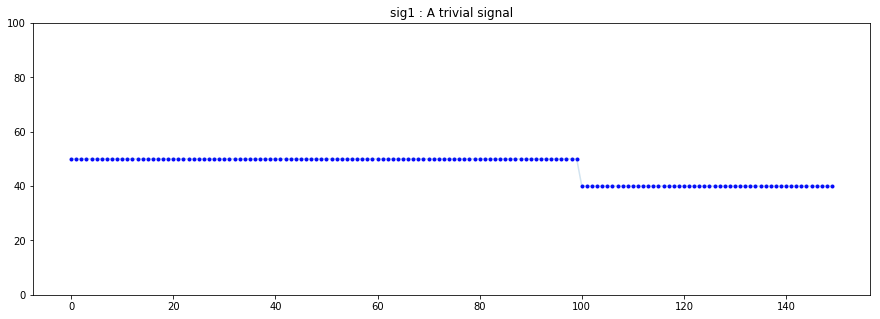

In [12]:
# A trivial signal

sig1 = np.ones(150)
sig1[:100] *= 50
sig1[100:] *= 40

plt.figure(figsize=(15, 5))
plt.plot(sig1, 'b.')
plt.plot(sig1, '-', alpha=0.2)
plt.ylim(0,100)
plt.title("sig1 : A trivial signal")

In [20]:
class ThresholdMeanDetector(ChangeDetector):
    """
    Static Mean Detector
    
    Residuals: 
        mean_: the mean of signal values seen so far
        diff_: the difference between new value and mean_
    
    Stopping Rule:
        Stop if diff_ exceeds some threshold percentage value. 
        Default is 5%.     
    """
    
    def __init__(self, threshold=0.05): 
        super(ThresholdMeanDetector, self ).__init__()

        # Save hyper-parameter(s)
        self.threshold = threshold
        
        # Required Attributes
        self.total_val = 0  # Used for calculating mean
        
        # new residuals(s)
        self.diff_ = np.nan 
    
    def update_residuals(self, new_signal_value):
        self._update_base_residuals(new_signal_value)

        # Update attributes
        self.total_val += new_signal_value
        
        #Update residuals 
        self.mean_ = self.total_val / self.signal_size
        self.diff_ = np.absolute(self.mean_ - new_signal_value)
    
    def check_stopping_rules(self, new_signal_value): 
        #check if new value is more than % different from mean
        threshold_level = self.mean_ * self.threshold
        
        if self.diff_ > threshold_level:
            self.rules_triggered = True

Residuals: ['diff_', 'mean_']
Change detected. Stopping Rule triggered at 100.



True

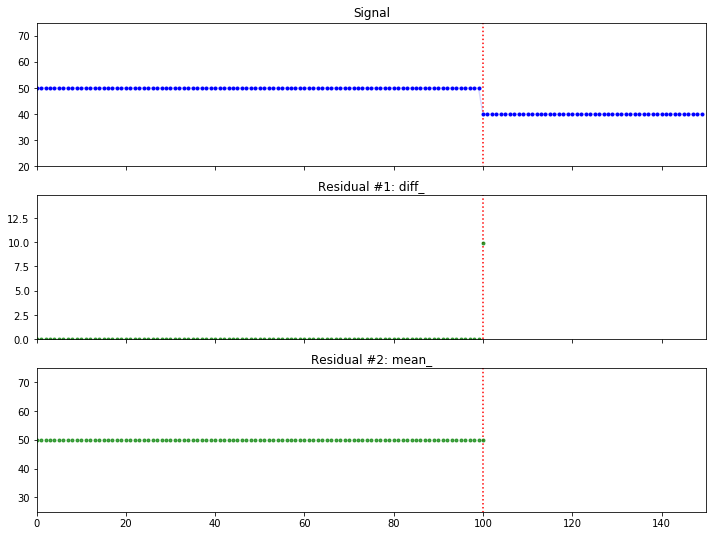

In [21]:
# Create detector
detector = ThresholdMeanDetector(threshold=0.05)

OnlineSimulator(detector, sig1).run()

In [22]:
from collections import deque

class ZScoreDetector(ChangeDetector):
    """
    A change detection algorithm based on z-scores
    ---
    1. We will use Welford's algorithm to collect mean and variance 
    of the full stream. 
    
    2. At the same time, we will collect a window of recent
    observations. We are storing all the recent observations for this
    window, and compute local statistics traditionally.
    
    3. Then, we compute a Z-score to compare the sample (window) 
    distribution to the population (global) distribution. 

    Our stopping rule is based on this computed z-score
    """
    
    def __init__(self, window_size = 100, threshold=0.05):
        super( ZScoreDetector, self ).__init__()
        
        # hyper-parameters
        self.threshold = threshold
        self.window_size = window_size
            
        # Interim and calculated values
        self.k = 0  # total signal_size
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        
        # This is the window
        self.window = deque(maxlen = window_size)
        
        # ... and, finally, our residuals
        self.z_score_ = np.nan
        self.z_array = []
        
    def update_residuals(self, new_signal_value):
        self._update_base_residuals(new_signal_value)
        x = new_signal_value
        
        # Add new value to local window (deque will
        #  automatically drop a value to maintain window size)
        self.window.append(x)
        
        """Calculate Statistics on global and local window """
        # Calculate global statistics using welford's method
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        
        g_mean = newm  # Global mean
        g_std = np.sqrt(s / (self.k+1))  # Global std
        
        # Calculate local statistics on the window
        #  We have all values stored for the window, so 
        #  can use built-in numpy stats methods
        w_mean = np.mean(self.window)  # Window mean
        w_std = np.std(self.window)  # Window std

        """Calculate variables required for Zscore"""
        # Calculate SE, see formula above
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        
        # Difference between the means
        mean_diff = (g_mean - w_mean) / g_mean
        
        # Z-score (residual)
        self.z_score_ = (w_mean - g_mean) / SE
        self.z_array.append(self.z_score_)
        
        # Store attributes
        self.g_mean = g_mean
        self.s = s
        
        # Update k (size of global window). 
        #   This must be done at the end!
        self.k += 1
    
    def check_stopping_rules(self, new_signal_value): 
        # Check stopping rule!
        if np.abs(self.z_score_) > self.threshold:
            self.rules_triggered = True

Residuals: ['z_score_']
Change detected. Stopping Rule triggered at 109.



c:\users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars
c:\users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars


True

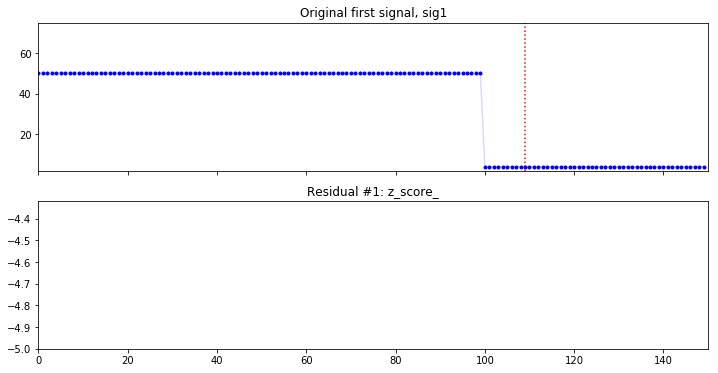

In [23]:
# Our first, most basic, signal. 

basic_sig = np.ones(150)
basic_sig[:100] *= 50
basic_sig[100:] *= 4

# On Signal 1
detector = ZScoreDetector(window_size = 10, threshold=10.0)
OnlineSimulator(detector, basic_sig).run(
     signal_name='Original first signal, sig1'
     )